In [14]:
import pyro
import numpy
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz

In [15]:
seed_value = 42  # Replace with your desired seed value
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
numpy.random.seed(seed_value)

# MAP or diagonal normal?
MAP=True
if MAP:
  MAXIT=2000 # SVI iterations
  REPORT=200 # Plot ELBO each time after this amount of SVI iterations
else:
  MAXIT=100000
  REPORT=1000

# Number of samples used in prediction
S=500

In [16]:
def accuracy(pred, data):
  """
  Calculate accuracy of predicted labels (integers).

  pred: predictions, tensor[sample_index, chain_index, data_index, logits]
  data: actual data (digit), tensor[data_index]

  Prediction is taken as most common predicted value.
  Returns accuracy (#correct/#total).
  """
  n=data.shape[0]
  correct=0
  total=0
  for i in range(0, n):
      # Get most common prediction value from logits
      pred_i=int(torch.argmax(torch.sum(pred[:,0,i,:],0)))
      # Compare prediction with data
      if int(data[i])==int(pred_i):
          correct+=1.0
      total+=1.0
  # Return fractional accuracy
  return correct/total

In [17]:
# Iris data set
Dx=4 # Input vector dim
Dy=3 # Number of labels

iris=sklearn.datasets.load_iris()
x_all=torch.tensor(iris.data, dtype=torch.float) # Input vector (4D)
y_all=torch.tensor(iris.target, dtype=torch.int) # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42)

print("Data set / test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set / test set sizes: 100, 50.


In [18]:
class Model:
    def __init__(self, x_dim=4, y_dim=3, h_dim=5):
        self.x_dim=x_dim
        self.y_dim=y_dim
        self.h_dim=h_dim

    def __call__(self, x, y=None):
        """
        We need None for predictive
        """
        x_dim=self.x_dim
        y_dim=self.y_dim
        h_dim=self.h_dim
        # Number of observations
        n=x.shape[0]
        # standard deviation of Normals
        sd=1 # EXERCISE: 100->1
        # Layer 1
        w1=pyro.sample("w1", pdist.Normal(0, sd).expand([x_dim, h_dim]).to_event(2))
        b1=pyro.sample("b1", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 2 # EXERCISE: added layer
        w2=pyro.sample("w2", pdist.Normal(0, sd).expand([h_dim, h_dim]).to_event(2))
        b2=pyro.sample("b2", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 3
        w3=pyro.sample("w3", pdist.Normal(0, sd).expand([h_dim, y_dim]).to_event(2))
        b3=pyro.sample("b3", pdist.Normal(0, sd).expand([y_dim]).to_event(1))
        # NN
        h1=torch.tanh((x @ w1) + b1)
        h2=torch.tanh((h1 @ w2) + b2) # EXERCISE: added layer
        logits=(h2 @ w3 + b3)
        # Save deterministc variable (logits) in trace
        pyro.deterministic("logits", logits)
        # Categorical likelihood
        with pyro.plate("labels", n):
            obs=pyro.sample("obs", pdist.Categorical(logits=logits), obs=y)

In [26]:
# Instantiate the Model object
model=Model()
# NUTS
nuts = pyro.infer.NUTS(model)

# Clear any previously used parameters
pyro.clear_param_store()

mcmc = pyro.infer.MCMC(nuts, num_samples=100, warmup_steps=50,num_chains=1)
mcmc.run(x, y)
samples = mcmc.get_samples()

Sample: 100%|██████████| 150/150 [05:50,  2.34s/it, step size=2.24e-02, acc. prob=0.428]


arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b1[0]     0.058  1.053  -2.026    1.671      0.224    0.093      28.0   
b1[1]    -1.054  0.903  -2.953    0.328      0.116    0.093      57.0   
b1[2]    -0.006  0.865  -1.692    1.254      0.131    0.111      42.0   
b1[3]    -0.192  0.840  -1.504    1.631      0.199    0.099      21.0   
b1[4]    -0.041  0.904  -1.812    1.291      0.149    0.176      41.0   
...         ...    ...     ...      ...        ...      ...       ...   
w3[3, 1]  0.326  1.338  -1.960    3.033      0.269    0.243      28.0   
w3[3, 2] -0.630  1.168  -2.619    1.785      0.155    0.096      60.0   
w3[4, 0]  0.884  1.081  -0.578    3.071      0.497    0.091       5.0   
w3[4, 1]  0.471  1.379  -1.804    2.134      0.419    0.078       9.0   
w3[4, 2] -0.928  1.296  -2.733    2.189      0.258    0.136      26.0   

          ess_tail  r_hat  
b1[0]         45.0    NaN  
b1[1]         52.0    NaN  
b1[2]         31.0    NaN  
b1[3]      

c:\Users\simon\AppData\Local\Programs\Python\Python313\Lib\site-packages\arviz\plots\plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_posterior, generating only 40 plots
  warnings.warn(
Warmup:   7%|▋         | 11/150 [13:33, 73.93s/it, step size=1.59e-02, acc. prob=0.674]


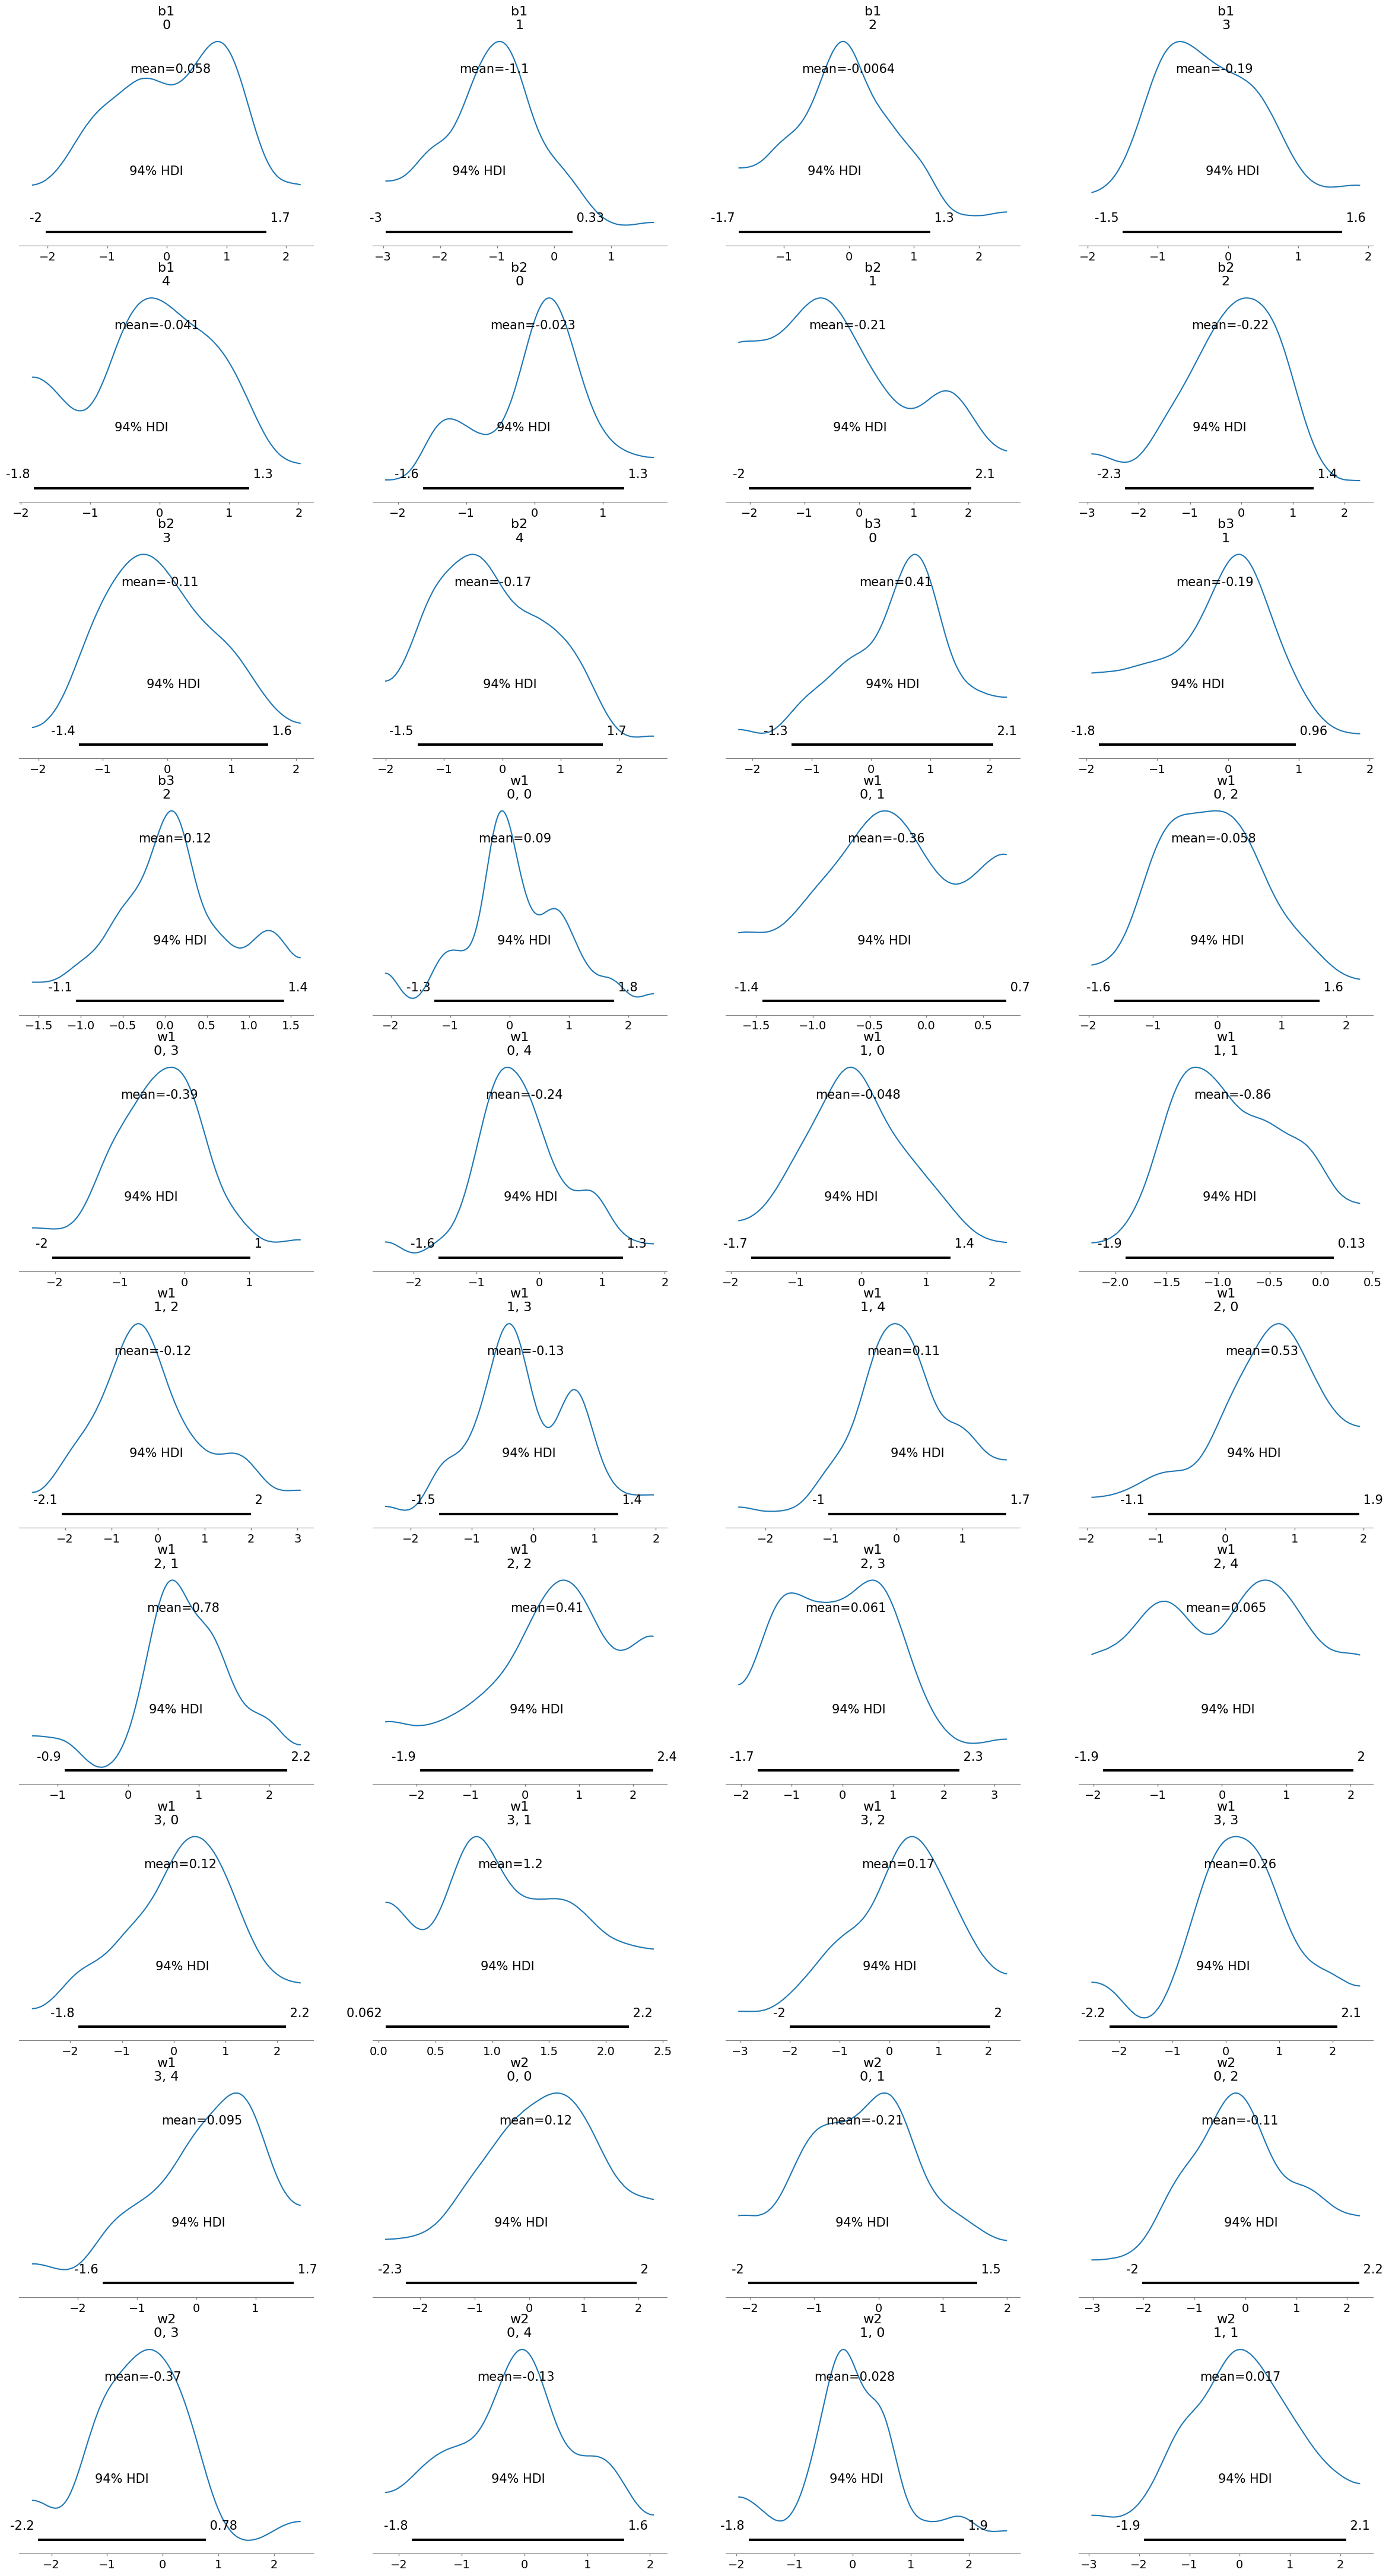

In [32]:
data1 = arviz.from_pyro(mcmc)
summary = arviz.summary(data1)
print(summary)
# Plot posterior:
arviz.plot_posterior(data1)
plt.show()